In this tutorial will write a alignment algorithm with MDAnalysis functions and later look into the documentation to find functions for the implementation of the algorithm.

In [2]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

First we have to load the trajectory we want to align and a reference structure.

In [3]:
trj = mda.Universe('data/adk.psf', 'data/adk_dims.dcd')
ref  = mda.Universe('data/adk.psf', 'data/adk_open.pdb')

# Develop Alignment Algorithm

We want to align align the ADK protein on the backbone of the open state. So the first thing is to create 
a selection of the backbone for the reference and trajectory.

In [4]:
ref_bb = ref.atoms.select_atoms('backbone')
trj_bb = trj.atoms.select_atoms('backbone')

## RMSD Calculation

Our alignment algorithm will be based on comparing the Root Mean Square Deviation (RMSD). The RMSD is a measure for the deviation of the distance between atoms in two structures.

\begin{align}
  RMSD(x, y) = \sqrt{\frac{\sum_{i=1}^{3N} (x_i - y_i)^2}{3N}}
\end{align}

$N$ is the number of atoms of both structures here. We can calculate the RMSD of the first frame in our trajectory with the reference

In [6]:
np.sqrt(np.sum((trj_bb.positions - ref_bb.positions))**2 / (3 * trj_bb.n_atoms))

340.74514400795215

** NOTE: **

The RMSD is sensitive to the origin of our structures. By common convention structures are normally centered
at either the center of mass or center of geometry before calculating the RMSD. We will use the center of mass now.

In [7]:
trj_xyz = trj_bb.positions - trj_bb.center_of_mass()
ref_xyz = ref_bb.positions - ref_bb.center_of_mass()

np.sqrt(np.sum((trj_xyz - ref_xyz) ** 2 / (3 * trj_bb.n_atoms)))

12.651793000729707

In [8]:
def RMSD(a, b):
    a_xyz = a.positions - a.center_of_mass()
    b_xyz = b.positions - b.center_of_mass()
    return np.sqrt(np.sum((a_xyz - b_xyz) ** 2 / (3 * a.n_atoms)))

For later comparison we will save the current RMSD in a variable called `RMSD_before`

In [9]:
RMSD_before = RMSD(trj.atoms, ref.atoms)
print('RMSD before alignment = {}'.format(RMSD_before))

RMSD before alignment = 12.7520205138


## Alignment of proteins

The alignment algorithm is based an RMSD comparison between two structures. This means we will determine a rotation matrix that minimizes the RMSD between two structures. We can use `MDAnalysis.analysis.align.rotation_matrix` for this.

Very important is that `rotation_matrix` is only calculating a rotation so we have to center both structures at the same point first. A common choice is the center of mass of the reference structure.

In [10]:
ref_bb_com = ref_bb.center_of_mass()
trj_bb_com = trj_bb.center_of_mass()

ref_xyz = ref_bb.positions - ref_bb_com
trj_xyz = trj_bb.positions - trj_bb_com

R, rmsd = mda.analysis.align.rotation_matrix(trj_xyz, ref_xyz)
print('RMSD after alignment = {}'.format(rmsd))

RMSD after alignment = 6.82368820119


R is the rotation_matrix we need to the alignment and rmsd is the RMSD after the alignment is done.

To align the structures in the lab coordinate system we can't just apply R. First we have to move the structures to be centered at `ref_bb_com` then we can rotate them. Later we have to move the structures back

In [11]:
trj.atoms.translate(-trj_bb_com)
trj.atoms.rotate(R)
trj.atoms.translate(trj_bb_com)

array([ 0.12435671, -0.00120173, -0.33425006])

Just for fun we can now check that the RMSD has changed using our own RMSD function

In [12]:
RMSD_after = RMSD(trj.atoms, ref.atoms)
print('RMSD before = {}'.format(RMSD_before))
print('RMSD after = {}'.format(RMSD_after))

RMSD before = 12.7520205138
RMSD after = 4.02327114509


## Align a complete trajectory.

Now we want to apply this algorithm on a complete trajectory and save the result in a file called `rmsd-fit.dcd`.

In [13]:
rmsd = np.zeros(len(trj.trajectory))

with mda.Writer('rmsd-fit.dcd', trj.atoms.n_atoms, 
                start=trj.trajectory.start_timestep,
                step=trj.trajectory.skip_timestep,
                dt=trj.trajectory.delta) as w:
    for i, ts in enumerate(trj.trajectory):
        com = trj_bb.center_of_mass()
        trj_xyz = trj_bb.positions - com
        R, rmsd[i] = mda.analysis.align.rotation_matrix(trj_xyz, ref_xyz)

        trj.atoms.translate(-com)
        trj.atoms.rotate(R)
        trj.atoms.translate(com)
        w.write(trj)

We can look how the structures slowly goes into the open conformation by plotting the RMSD value after the alignment vs the frame.

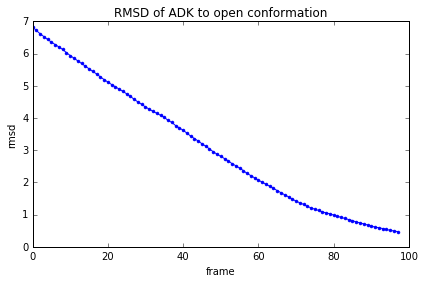

In [14]:
f, ax = plt.subplots()

ax.plot(rmsd, '.-')
ax.set(xlabel='frame', ylabel='rmsd',
       title='RMSD of ADK to open conformation')
plt.tight_layout()

# Use MDAnalysis algorithm

For convenience MDAnalysis already includes a function which makes the alignment of two proteins easy.

In [15]:
rmsd_mda = np.zeros((len(trj.trajectory), 2))

with mda.Writer('rms-alignment.dcd', trj.atoms.n_atoms, 
                start=trj.trajectory.start_timestep,
                step=trj.trajectory.skip_timestep,
                dt=trj.trajectory.delta) as w:
    for i, ts in enumerate(trj.trajectory):
        rmsd_mda[i] = mda.analysis.align.alignto(trj, ref, select='backbone')
        w.write(trj)

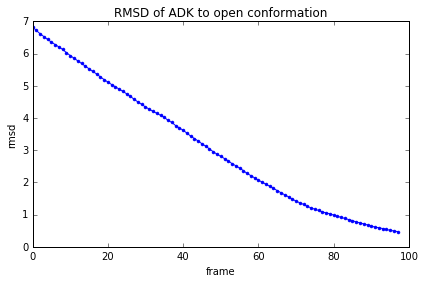

In [16]:
f, ax = plt.subplots()

# the aligned rmsd is saved in the second column of the array
ax.plot(rmsd_mda[:, 1], '.-')
ax.set(xlabel='frame', ylabel='rmsd',
       title='RMSD of ADK to open conformation')
plt.tight_layout()